In [1]:
import sys
sys.path.append('../../')
import torch
from torchvision.datasets import MNIST
from torchvision import transforms
import time

from torch.utils.data import DataLoader
from Code.Networks import OuterWrapper


In [2]:
BATCH_SIZE = 1024

USE_JIT = False

device = torch.device('cuda')

In [3]:
test = MNIST('../../', transform=transforms.ToTensor(), train=False)

In [4]:

test_loader = DataLoader(test, batch_size=BATCH_SIZE, drop_last=False, num_workers=0)



In [5]:
model_name = 'big11'
n_models = 16

In [7]:
with torch.no_grad():
    for m in range(n_models):
        mem_model = OuterWrapper(torch.load('../../models/mem_'+model_name+'_'+str(m)), device, USE_JIT)
        post_model = OuterWrapper(torch.load('../../models/post_'+model_name+'_'+str(m)), device, USE_JIT)
        confusion = torch.zeros([10,10])
        i = 0
        acc = 0
        for inp, target in test_loader:
            x = inp.view(inp.shape[0], -1, 1).transpose(0,1).to(device)
            target = target.to(device)
            mem, _ = mem_model(x)
            outputs, _ = post_model(mem[-1].expand(56, x.shape[1], 256))
            choice = torch.argmax(outputs.mean(dim=0), 1)
            acc += (choice == target).float().mean()
            i += 1
            for k in range(len(target)):
                confusion[choice[k], target[k]] += 1
        print('Model '+str(m)+': '+str(acc/i))
#print(confusion)

Model 0: tensor(0.9225, device='cuda:0')
Model 1: tensor(0.9161, device='cuda:0')
Model 2: tensor(0.9167, device='cuda:0')
Model 3: tensor(0.9227, device='cuda:0')
Model 4: tensor(0.9212, device='cuda:0')
Model 5: tensor(0.9180, device='cuda:0')
Model 6: tensor(0.9232, device='cuda:0')
Model 7: tensor(0.9244, device='cuda:0')
Model 8: tensor(0.9102, device='cuda:0')
Model 9: tensor(0.9204, device='cuda:0')
Model 10: tensor(0.9185, device='cuda:0')
Model 11: tensor(0.9265, device='cuda:0')
Model 12: tensor(0.9254, device='cuda:0')
Model 13: tensor(0.9191, device='cuda:0')
Model 14: tensor(0.9210, device='cuda:0')
Model 15: tensor(0.9223, device='cuda:0')


In [7]:
max = confusion.max().item()
from PIL import Image
img = Image.new('L',(10,10),color=128)
for i in range(10):
    for k in range(10):
        img.putpixel((i, k), int(confusion[i,k]/max*255))

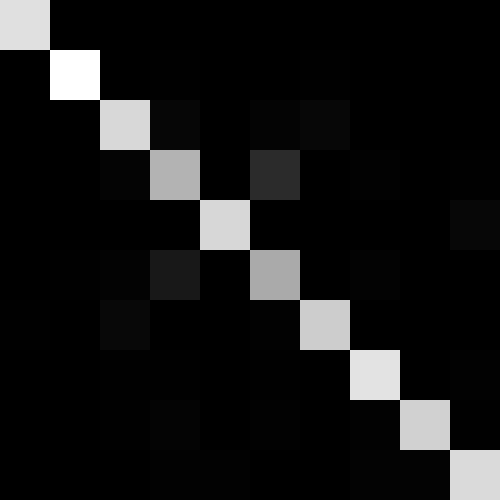

In [8]:
img.resize((500, 500))

In [9]:
testi = MNIST('../../', train=False)

In [ ]:
show = []
schoice = []
starget = []
for img, target in testi:
    x = transforms.ToTensor()(img).view(-1, 1, 1).to(device)
    mem, _ = mem_model(x)
    outputs, _ = post_model(mem[-1].expand(56, 1, 256))
    choice = torch.argmax(outputs.mean(dim=0), 1).item()
    if choice != target:
        show.append(img)
        schoice.append(choice)
        starget.append(target)
        if len(show) == 10:
            break


In [ ]:
show[7].resize((500,500))


In [ ]:
print(schoice)
print(starget)

In [ ]:
mem_model.model.model.layers.shortterm_synapse.named_parameters()

In [ ]:
for name, p in n_mem.named_parameters():
    print(name, p.shape)

In [ ]:
for name, p in mem_model2.named_parameters():
    print(name, p.shape)

In [ ]:
mem_model2 = torch.load('../../models/mem_nores3_76')
n_mem = make_SequenceWrapper(DynNetwork(mem_loop), USE_JIT)
with torch.no_grad():
    n_mem.model.layers.output_synapse.weight = mem_model2.model.layers.output_synapse.weight
    n_mem.model.layers.output_synapse.bias = mem_model2.model.layers.output_synapse.bias
    n_mem.model.layers.output.initial_mem = mem_model2.model.layers.output.initial_mem
    n_mem.model.layers.pre_mem_synapse.bias = mem_model2.model.layers.pre_mem_synapse.bias
    n_mem.model.layers.pre_mem.initial_mem = mem_model2.model.layers.pre_mem.initial_mem
    n_mem.model.layers.pre_mem_synapse.weight[:, :129] = mem_model2.model.layers.pre_mem_synapse.weight

In [ ]:
data_loader.__iter__().__next__()[1]